# Introduction

## Business Question

---

> **Guiding question:** What are the top 5 zip codes based on the ROI for the cit of Pittsburgh?
>
>
> **Evaluation Metric:** ROI/Risk
>
>
> **Dataset:** Zillow data from 1996-2018
>
>
> **Goal:** time series modeling for each zip code to calculate forecasted sale prices.
>
>
> 

---

# **Workflow: Start -> Finish**

## Import

In [76]:
# import warnings
# warnings.filterwarnings('ignore')

## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd

## Settings
%matplotlib inline
plt.rcParams['figure.figsize']=(15,10)
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 100)

from bmc_functions import eda, time_series_modeling
from bmc_functions import time_series_modeling as tsm

In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading Data

In [78]:
## Reading data
source = '../data/zillow_data.csv'
data = pd.read_csv(source)
data

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00","337,600.00","338,500.00","339,500.00","340,400.00","341,300.00","342,600.00","344,400.00","345,700.00","346,700.00","347,800.00","349,000.00","350,400.00","352,000.00","353,900.00","356,200.00","358,800.00","361,800.00","365,700.00","370,200.00","374,700.00","378,900.00","383,500.00","388,300.00","393,300.00","398,500.00","403,800.00","409,100.00","414,600.00","420,100.00","426,200.00","432,600.00","438,600.00","444,200.00","450,000.00","455,900.00","462,100.00","468,500.00","475,300.00","482,500.00","490,200.00","498,200.00","507,200.00","516,800.00","526,300.00","535,300.00","544,500.00","553,500.00","562,400.00","571,200.00","579,800.00","588,100.00","596,300.00","604,200.00","612,200.00","620,200.00","627,700.00","634,500.00","641,000.00","647,000.00","652,700.00","658,100.00","663,300.00","668,400.00","673,400.00","678,300.00","683,200.00","688,300.00","693,300.00","698,000.00","702,400.00","706,400.00","710,200.00","714,000.00","717,800.00","721,700.00","725,700.00","729,900.00","733,400.00","735,600.00","737,200.00","739,000.00","740,900.00","742,700.00","744,400.00","746,000.00","747,200.00","748,000.00","749,000.00","750,200.00","752,300.00","755,300.00","759,200.00","764,000.00","769,600.00","775,600.00","781,900.00","787,900.00","793,200.00","798,200.00","803,100.00","807,900.00","812,900.00","818,100.00","823,100.00","828,300.00","834,100.00","839,800.00","845,600.00","851,800.00","858,000.00","864,400.00","870,700.00","876,200.00","880,700.00","884,400.00","887,600.00","890,500.00","893,300.00","895,500.00","897,300.00","899,000.00","900,400.00","902,000.00","904,400.00","907,100.00","909,700.00","911,900.00","913,000.00","913,000.00","912,000.00","909,300.00","905,300.00","901,400.00","897,900.00","

In [79]:
## Initial inspection
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


## Creating Subset of Zipcodes

---

> The dataset is much larger than I need for my purposes, so I will select only the zip codes for the Pittsburgh Metro area.
>
>
> To select this data, I will filter the initial dataframe by selecting "Pittsburgh" from the "city" column.

---

In [80]:
## Selecting the city of Pittsburgh 

pitt_df = data[data['City'] == 'Pittsburgh']
pitt_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1928,63937,15206,Pittsburgh,PA,Pittsburgh,Allegheny,1929,"50,200.00","50,300.00","50,300.00","50,300.00","50,300.00","50,400.00","50,400.00","50,400.00","50,500.00","50,500.00","50,600.00","50,500.00","50,500.00","50,500.00","50,400.00","50,400.00","50,400.00","50,300.00","50,400.00","50,400.00","50,500.00","50,700.00","50,900.00","51,200.00","51,400.00","51,800.00","52,200.00","52,600.00","53,100.00","53,700.00","54,100.00","54,600.00","55,000.00","55,400.00","55,600.00","55,700.00","55,600.00","55,500.00","55,300.00","55,000.00","54,700.00","54,300.00","54,000.00","53,800.00","53,700.00","53,600.00","53,700.00","53,700.00","54,000.00","54,300.00","54,800.00","55,300.00","55,900.00","56,500.00","57,200.00","58,000.00","58,800.00","59,500.00","60,100.00","60,600.00","61,100.00","61,500.00","61,900.00","62,300.00","62,600.00","63,000.00","63,300.00","63,700.00","64,000.00","64,300.00","64,400.00","64,500.00","64,600.00","64,500.00","64,500.00","64,300.00","64,200.00","64,200.00","64,200.00","64,100.00","64,000.00","64,200.00","64,800.00","65,400.00","66,000.00","66,600.00","67,300.00","67,900.00","68,600.00","69,200.00","69,600.00","69,900.00","70,300.00","70,900.00","71,500.00","72,200.00","72,900.00","73,600.00","74,300.00","74,900.00","75,400.00","75,900.00","76,300.00","76,700.00","76,800.00","76,600.00","76,100.00","75,500.00","74,900.00","74,400.00","74,100.00","73,900.00","73,800.00","73,600.00","73,500.00","73,600.00","73,900.00","74,300.00","75,000.00","75,700.00","76,500.00","77,200.00","77,800.00","78,400.00","79,000.00","79,600.00","80,200.00","80,600.00","80,700.00","80,500.00","80,100.00","79,600.00","79,200.00","78,700.00","78,300.00","78,000.00","77,800.00","77,700.00","77,900.00","78,300.00","78,800.00","79,400.00","80,300.00","81,500.00","82,900.00","84,400.00","86,100.00","

In [81]:
## Examining statistics for the new dataframe
eda.report_df(pitt_df).T

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,City,CountyName,Metro,RegionID,RegionName,SizeRank,State
null_sum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null_pct,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

## ❌ EDIT OUT - Pivot Table

In [82]:
# ## EDITED OUT - POTENTIALLY INACCURATE/INCONSISTENT DATA
# ## Inspecting overall data - transposed and dropping RegionID, SizeRank

# pitt_pivoted = pitt_df.pivot_table(index='RegionName').T[:-2].loc['2008':]
# pitt_pivoted

# Melting DataFrame

In [83]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe with the datetime column names
    as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank',
                                  'City', 'State', 'Metro', 'CountyName'],
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [84]:
## Melting the dataframe to move the dates from columns into a new row per zipcode
pitt_melted = melt_data(pitt_df)
pitt_melted

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,15206,63937,1929,Pittsburgh,PA,Pittsburgh,Allegheny,1996-04-01,"50,200.00"
1,15212,63943,2288,Pittsburgh,PA,Pittsburgh,Allegheny,1996-04-01,"38,800.00"
2,15217,63948,2941,Pittsburgh,PA,Pittsburgh,Allegheny,1996-04-01,"105,400.00"
3,15213,63944,3326,Pittsburgh,PA,Pittsburgh,Allegheny,1996-04-01,"41,200.00"
4,15210,63941,3712,Pittsburgh,PA,Pittsburgh,Allegheny,1996-04-01,"33,400.00"
...,...,...,...,...,...,...,...,...,...
5030,15211,63942,6935,Pittsburgh,PA,Pittsburgh,Allegheny,2018-04-01,"128,400.00"
5031,15243,63974,7027,Pittsburgh,PA,Pittsburgh,Allegheny,2018-04-01,"224,800.00"
5032,15207,63938,7586,Pittsburgh,PA,Pittsburgh,Allegheny,2018-04-01,"90,100.00"
5033,15204,63935,8949,Pittsburgh,PA,Pittsburgh,Allegheny,2018-04-01,"63,000.00"


In [85]:
## Confirming conversion to "datetime" datatype
pitt_melted['time']

0      1996-04-01
1      1996-04-01
2      1996-04-01
3      1996-04-01
4      1996-04-01
          ...    
5030   2018-04-01
5031   2018-04-01
5032   2018-04-01
5033   2018-04-01
5034   2018-04-01
Name: time, Length: 5035, dtype: datetime64[ns]

In [86]:
## Selecting columns to keep for modeling
keep = ['RegionName', 'time', 'value']

In [87]:
pitt_data = pitt_melted[keep]
pitt_data

,RegionName,time,value
0,15206,1996-04-01,"50,200.00"
1,15212,1996-04-01,"38,800.00"
2,15217,1996-04-01,"105,400.00"
3,15213,1996-04-01,"41,200.00"
4,15210,1996-04-01,"33,400.00"
...,...,...,...
5030,15211,2018-04-01,"128,400.00"
5031,15243,2018-04-01,"224,800.00"
5032,15207,2018-04-01,"90,100.00"
5033,15204,2018-04-01,"63,000.00"


In [88]:
pitt_data.set_index('time', inplace=True)
pitt_data

,RegionName,value
time,,
1996-04-01,15206,"50,200.00"
1996-04-01,15212,"38,800.00"
1996-04-01,15217,"105,400.00"
1996-04-01,15213,"41,200.00"
1996-04-01,15210,"33,400.00"
...,...,...
2018-04-01,15211,"128,400.00"
2018-04-01,15243,"224,800.00"
2018-04-01,15207,"90,100.00"


---

> **The following code is adapted from code within [this notebook](https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_4/topic_37_intro_to_time_series/topic_37_intro_to_time_series_crime_v3-SG.ipynb) by James Irving, Ph.D.**

---

In [89]:
## Creating list of unique zipcodes from the dataframe
zipcodes = list(pitt_data['RegionName'].unique())
zipcodes

[15206,
 15212,
 15217,
 15213,
 15210,
 15205,
 15216,
 15220,
 15228,
 15232,
 15201,
 15214,
 15226,
 15203,
 15211,
 15243,
 15207,
 15204,
 15233]

In [90]:
## Inspecting first zipcode in list - datetime index and associated sell value
test_code = zipcodes[0]
test_zipcode_series = pitt_data.groupby('RegionName')\
                                .get_group(test_code)['value']\
                                                            .rename(test_code)
test_zipcode_series

time
1996-04-01    50,200.00
1996-05-01    50,300.00
1996-06-01    50,300.00
1996-07-01    50,300.00
1996-08-01    50,300.00
                ...    
2017-12-01   174,500.00
2018-01-01   176,800.00
2018-02-01   179,600.00
2018-03-01   185,500.00
2018-04-01   191,100.00
Name: 15206, Length: 265, dtype: float64

In [91]:
## Creating a dictionary to store each zipcode and its timeseries data

zipcodes_dict = {}

for zipcode in zipcodes:
    
    ## Create the series for each zipcode
    zipcode_series = pitt_data.groupby('RegionName')\
                                                .get_group(zipcode)['value']\
                                                            .rename(zipcode)
    
    ## Save in zipcode dictionary
    zipcodes_dict[zipcode] = zipcode_series
    
## Display the keys
zipcodes_dict.keys()

dict_keys([15206, 15212, 15217, 15213, 15210, 15205, 15216, 15220, 15228, 15232, 15201, 15214, 15226, 15203, 15211, 15243, 15207, 15204, 15233])

In [92]:
## Confirming all zip codes are present in dictionary
list(zipcodes_dict.keys()) == zipcodes

True

In [93]:
zipcodes_dict[15206]

time
1996-04-01    50,200.00
1996-05-01    50,300.00
1996-06-01    50,300.00
1996-07-01    50,300.00
1996-08-01    50,300.00
                ...    
2017-12-01   174,500.00
2018-01-01   176,800.00
2018-02-01   179,600.00
2018-03-01   185,500.00
2018-04-01   191,100.00
Name: 15206, Length: 265, dtype: float64

In [94]:
zipcodes_df_full = pd.DataFrame(zipcodes_dict)
zipcodes_df_full

,15206,15212,15217,15213,15210,15205,15216,15220,15228,15232,15201,15214,15226,15203,15211,15243,15207,15204,15233
time,,,,,,,,,,,,,,,,,,,
1996-04-01,"50,200.00","38,800.00","105,400.00","41,200.00","33,400.00","69,800.00","64,000.00","85,400.00","122,900.00","146,700.00","34,400.00","55,100.00","60,600.00","38,700.00","38,600.00","113,300.00","42,800.00","44,600.00","41,000.00"
1996-05-01,"50,300.00","38,800.00","105,600.00","41,100.00","33,500.00","69,700.00","63,700.00","85,200.00","122,300.00","146,900.00","34,600.00","54,900.00","60,300.00","38,500.00","38,600.00","112,700.00","42,800.00","44,500.00","40,900.00"
1996-06-01,"50,300.00","38,900.00","105,800.00","41,000.00","33,600.00","69,500.00","63,400.00","85,000.00","121,700.00","147,000.00","34,700.00","54,700.00","60,000.00","38,200.00","38,600.00","112,200.00","42,900.00","44,500.00","40,700.00"
1996-07-01,"50,300.00","39,000.00","105,900.00","40,900.00","33,700.00","69,300.00","63,000.00","84,900.00","121,100.00","147,100.00","34,700.00","54,500.00","59,600.00","37,900.00","38,500.00","111,700.00","42,900.00","44,400.00","40,600.00"
1996-08-01,"50,300.00","39,000.00","106,000.00","40,800.00","33,800.00","69,200.00","62,700.00","84,700.00","120,600.00","147,300.00","34,800.00","54,300.00","59,200.00","37,700.00","38,500.00","111,200.00","43,000.00","44,400.00","40,400.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,"174,500.00","78,700.00","303,400.00","186,700.00","45,500.00","131,000.00","131,900.00","156,100.00","268,500.00","507,500.00","170,400.00","104,800.00","120,300.00","168,200.00","119,000.00","219,900.00","85,500.00","59,600.00","125,200.00"
2018-01-01,"176,800.00","79,700.00","304,900.00","188,000.00","45,700.00","130,500.00","132,400.00","156,700.00","268,400.00","511,700.00","171,400.00","107,200.00","120,900.00","168,100.00","120,800.00","220,300.00","85,800.00","60,200.00","126,200.00"
2018-02-01,"179,600.00","81,100.00","307,800.00","188,900.00","46,300.00","130,600.00","133,500.00","157,600.00","269,000.00","513,000.00","173,900.00","108,600.00","121,700.00","169,000.00","123,600.00","221,600.00","87,000.00","61,200.00","129,300.00"


In [95]:
zipcodes_df = zipcodes_df_full.loc['2008':]
zipcodes_df

,15206,15212,15217,15213,15210,15205,15216,15220,15228,15232,15201,15214,15226,15203,15211,15243,15207,15204,15233
time,,,,,,,,,,,,,,,,,,,
2008-01-01,"79,400.00","58,400.00","202,300.00","88,600.00","40,200.00","96,900.00","90,800.00","123,900.00","187,600.00","314,800.00","67,100.00","78,000.00","78,000.00","105,600.00","66,100.00","166,400.00","66,500.00","57,700.00","94,000.00"
2008-02-01,"80,300.00","58,400.00","202,000.00","88,700.00","39,600.00","97,200.00","90,900.00","123,700.00","187,200.00","315,800.00","67,700.00","78,100.00","78,200.00","107,300.00","65,700.00","166,400.00","66,400.00","57,700.00","92,600.00"
2008-03-01,"81,500.00","58,100.00","201,700.00","88,700.00","39,100.00","97,500.00","91,000.00","123,400.00","186,700.00","316,600.00","68,400.00","78,000.00","78,400.00","108,700.00","65,100.00","166,400.00","66,400.00","57,700.00","91,300.00"
2008-04-01,"82,900.00","57,600.00","201,500.00","88,700.00","38,400.00","97,800.00","91,100.00","123,000.00","185,900.00","317,100.00","69,500.00","77,800.00","78,700.00","109,800.00","64,600.00","166,400.00","66,400.00","57,600.00","90,100.00"
2008-05-01,"84,400.00","57,000.00","201,800.00","88,800.00","37,900.00","98,200.00","91,100.00","122,600.00","185,000.00","316,700.00","70,500.00","77,700.00","79,000.00","110,800.00","64,400.00","166,400.00","66,600.00","57,600.00","88,200.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,"174,500.00","78,700.00","303,400.00","186,700.00","45,500.00","131,000.00","131,900.00","156,100.00","268,500.00","507,500.00","170,400.00","104,800.00","120,300.00","168,200.00","119,000.00","219,900.00","85,500.00","59,600.00","125,200.00"
2018-01-01,"176,800.00","79,700.00","304,900.00","188,000.00","45,700.00","130,500.00","132,400.00","156,700.00","268,400.00","511,700.00","171,400.00","107,200.00","120,900.00","168,100.00","120,800.00","220,300.00","85,800.00","60,200.00","126,200.00"
2018-02-01,"179,600.00","81,100.00","307,800.00","188,900.00","46,300.00","130,600.00","133,500.00","157,600.00","269,000.00","513,000.00","173,900.00","108,600.00","121,700.00","169,000.00","123,600.00","221,600.00","87,000.00","61,200.00","129,300.00"


# T/T Split

In [96]:
## Testing first zipcode from dictionary
zipcode_val = zipcodes_df[15206].copy()
zipcode_val

time
2008-01-01    79,400.00
2008-02-01    80,300.00
2008-03-01    81,500.00
2008-04-01    82,900.00
2008-05-01    84,400.00
                ...    
2017-12-01   174,500.00
2018-01-01   176,800.00
2018-02-01   179,600.00
2018-03-01   185,500.00
2018-04-01   191,100.00
Name: 15206, Length: 124, dtype: float64

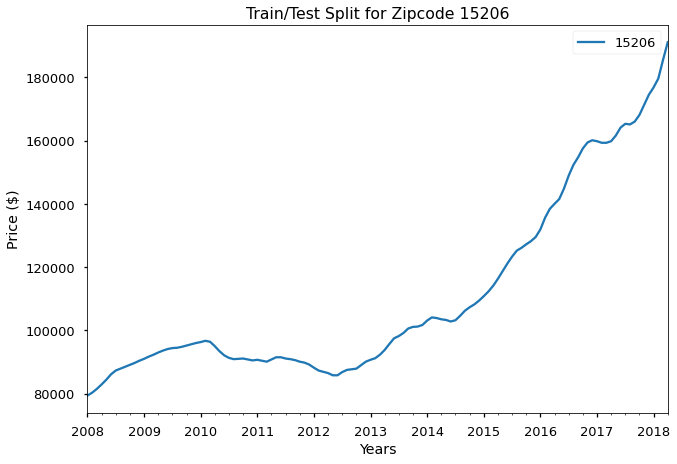

In [97]:
## Plotting first zipcode to test

fig, ax = plt.subplots()
ax = zipcode_val.plot()
ax.legend()
ax.set_xlabel('Years')
ax.set_ylabel('Price ($)')
ax.set_title(f'Train/Test Split for Zipcode {zipcode_val.name}')
plt.show()

In [98]:
# ## Creating a function to streamline plotting all of the zipcodes

# def ts_split(timeseries_df, threshold):
#     tts_cutoff = round(timeseries_df.shape[0]*threshold)
#     train = timeseries_df.iloc[:tts_cutoff]
#     test = timeseries_df.iloc[tts_cutoff:]

#     ## Plot
#     fig, ax = plt.subplots()
#     ax = train.plot(label='Train')
#     ax = test.plot(label='Test')
#     ax.legend()
#     ax.set_xlabel('Years')
#     ax.set_ylabel('Price ($)')
#     ax.set_title(f'Train/Test Split for Zipcode {timeseries_df.name}')
#     ax.axvline(train.index[-1], linestyle=":")
#     plt.show();
    
#     return train, test

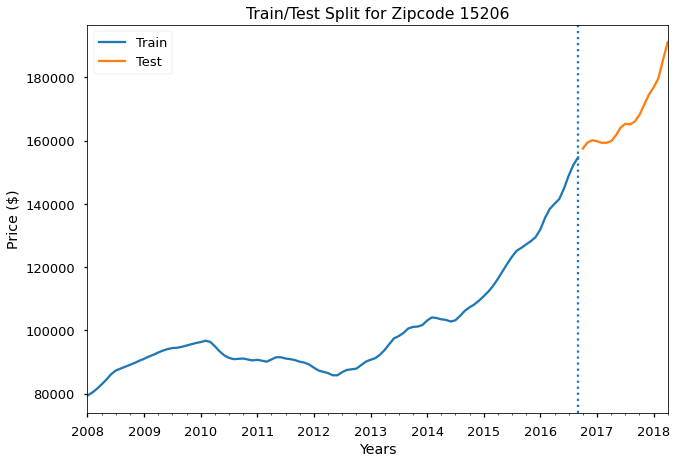

In [99]:
## Creating train/test split for first zipcode
train, test = tsm.ts_split(zipcode_val)

In [100]:
## Inspecting training set
train

time
2008-01-01    79,400.00
2008-02-01    80,300.00
2008-03-01    81,500.00
2008-04-01    82,900.00
2008-05-01    84,400.00
                ...    
2016-05-01   141,500.00
2016-06-01   144,800.00
2016-07-01   148,900.00
2016-08-01   152,300.00
2016-09-01   154,700.00
Name: 15206, Length: 105, dtype: float64

In [101]:
## Inspecting testing set
test

time
2016-10-01   157,500.00
2016-11-01   159,400.00
2016-12-01   160,100.00
2017-01-01   159,800.00
2017-02-01   159,300.00
2017-03-01   159,300.00
2017-04-01   159,800.00
2017-05-01   161,600.00
2017-06-01   164,100.00
2017-07-01   165,300.00
2017-08-01   165,100.00
2017-09-01   166,000.00
2017-10-01   168,100.00
2017-11-01   171,300.00
2017-12-01   174,500.00
2018-01-01   176,800.00
2018-02-01   179,600.00
2018-03-01   185,500.00
2018-04-01   191,100.00
Name: 15206, dtype: float64

In [102]:
len(test)

19

# Stationarity Check

---

> The following functions are adapted from [this notebook](https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_4/topic_37_intro_to_time_series/topic_37_intro_to_time_series_crime_v3-SG.ipynb) by James Irving, Ph.D.

---

## Dickey Fuller Test

In [103]:
## Performing Dickey-Fuller Test
zipdf_results = tsa.stattools.adfuller(train)
zipdf_results

(2.0709935061877904,
 0.9987583894364246,
 3,
 101,
 {'1%': -3.4968181663902103,
  '5%': -2.8906107514600103,
  '10%': -2.5822770483285953},
 1370.270091934341)

In [104]:
## Creating a dictionary to store initial results
index_label =[f'{train.name}']
labels = ['Test Stat','P-Value','Number of Lags Used','Number of Obs. Used',
        'Critical Thresholds', 'AIC Value']
results_dict  = dict(zip(labels,zipdf_results))

## Saving results to a dictionary and adding T/F for whether exceeds standard
## p-value of .05 and if we fail to reject the null hypothesis or not.
results_dict['p < .05'] = results_dict['P-Value']<.05
results_dict['Stationary'] = results_dict['p < .05']

## Creating DataFrame from dictionary
if isinstance(index_label,str):
    index_label = [index_label]
results_dict = pd.DataFrame(results_dict,index=index_label)
results_dict = results_dict[['Test Stat','P-Value','Number of Lags Used',
                             'Number of Obs. Used','P-Value','p < .05',
                             'Stationary']]

results_dict

,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < .05,Stationary
15206,2.07,1.00,3,101,1.00,False,False


In [105]:
## Functionizing ADF test process

def adf_test(ts, p = .05):
    zipdf_results = tsa.stattools.adfuller(ts)
    
    index_label = [f'Results: {ts.name}']
    labels = ['Test Stat','P-Value','Number of Lags Used','Number of Obs. Used',
            'Critical Thresholds', 'AIC Value']
    results_dict  = dict(zip(labels,zipdf_results))

    ## Saving results to a dictionary and adding T/F for whether exceeds standard
    ## p-value of .05 and if we fail to reject the null hypothesis or not.
    results_dict[f'p < {p}'] = results_dict['P-Value']< p
    results_dict['Stationary'] = results_dict[f'p < {p}']

    ## Creating DataFrame from dictionary
    if isinstance(index_label,str):
        index_label = [index_label]
    results_dict = pd.DataFrame(results_dict,index=index_label)
    results_dict = results_dict[['Test Stat','P-Value','Number of Lags Used',
                                 'Number of Obs. Used','P-Value',f'p < {p}',
                                 'Stationary']]
    
    return results_dict

In [106]:
## Testing functionality
adf_test(train)

,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < 0.05,Stationary
Results: 15206,2.07,1.00,3,101,1.00,False,False


## Removing Trends, Seasonality

In [107]:
## Setting variable for reuse in 
test_zip = train

| --- Zipcode 15206 --- | 

time
2008-02-01     900.00
2008-03-01   1,200.00
2008-04-01   1,400.00
2008-05-01   1,500.00
2008-06-01   1,700.00
               ...   
2016-05-01   1,500.00
2016-06-01   3,300.00
2016-07-01   4,100.00
2016-08-01   3,400.00
2016-09-01   2,400.00
Name: 15206, Length: 104, dtype: float64


 | -------------------- ADF Results for Zipcode 15206 ------------------------------ |


,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < 0.05,Stationary
Results: 15206,-1.16,0.69,2,101,0.69,False,False




 | ---------------------------- Visualizing Difference Shift --------------------- |


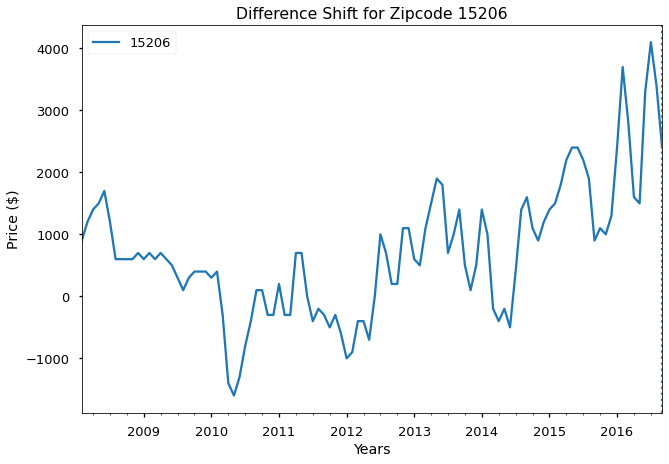

In [108]:
## Testing differenced data
tz_diff = train.diff().dropna()
print("|","---",f"Zipcode {train.name}","---","|","\n")
print(tz_diff)
print('\n\n',"|","----"*5,f"ADF Results for Zipcode {train.name}","-----"*6,"|")
display(adf_test(tz_diff))

print('\n\n','|',"----"*7,f"Visualizing Difference Shift","---"*7,"|")
fig, ax = plt.subplots()
ax = tz_diff.plot(label=f'{train.name}')
ax.legend()
ax.set_xlabel('Years')
ax.set_ylabel('Price ($)')
ax.set_title(f'Difference Shift for Zipcode {train.name}')
ax.axvline(train.index[-1], linestyle=":")
plt.show();

In [109]:
## Functionizing plotting/eval code
def remove_trends(timeseries, method, window = 4):
    if method == 'diff':
        results = timeseries.diff().dropna()
    elif method == 'log':
        results = np.log(timeseries)
    elif method == 'rolling' or method == 'rolling mean':
        results = timeseries - timeseries.rolling(window = window).mean()
        results.dropna(inplace=True)
    elif method == 'ewm' or method == 'EWM':
        results = tz_ewm = test_zip-test_zip.ewm(4).mean()
        results.dropna(inplace=True)
    
    print("|","---"*7,f"{method.title()} Effect on Zipcode {timeseries.name}",
      "-----"*6,"|",'\n\n')
    print("|","---",f"Zipcode {timeseries.name}","---","|","\n")
    print(results)
    print('\n\n',"|","----"*5,f"ADF Results for Zipcode {timeseries.name}",
          "-----"*6,"|")
    display(adf_test(results))

    print('\n\n','|',"---"*8,f"Visualizing {method.title()} Effect","----"*8,
          "|")
    fig, ax = plt.subplots()
    ax = results.plot(label=f'{timeseries.name}')
    ax.legend()
    ax.set_xlabel('Years')
    ax.set_ylabel('Price ($)')
    if method != 'ewm' and method != 'EWM':
        ax.set_title(f'{method.title()} Effect on Zipcode {timeseries.name}')
    else:
        ax.set_title(f'{method.capitalize()} Effect on Zipcode \
                                                        {timeseries.name}')
    ax.axvline(timeseries.index[-1], linestyle=":")
    plt.show();
    
    return results

| --------------------- Diff Effect on Zipcode 15206 ------------------------------ | 


| --- Zipcode 15206 --- | 

time
2008-02-01     900.00
2008-03-01   1,200.00
2008-04-01   1,400.00
2008-05-01   1,500.00
2008-06-01   1,700.00
               ...   
2016-05-01   1,500.00
2016-06-01   3,300.00
2016-07-01   4,100.00
2016-08-01   3,400.00
2016-09-01   2,400.00
Name: 15206, Length: 104, dtype: float64


 | -------------------- ADF Results for Zipcode 15206 ------------------------------ |


,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < 0.05,Stationary
Results: 15206,-1.16,0.69,2,101,0.69,False,False




 | ------------------------ Visualizing Diff Effect -------------------------------- |


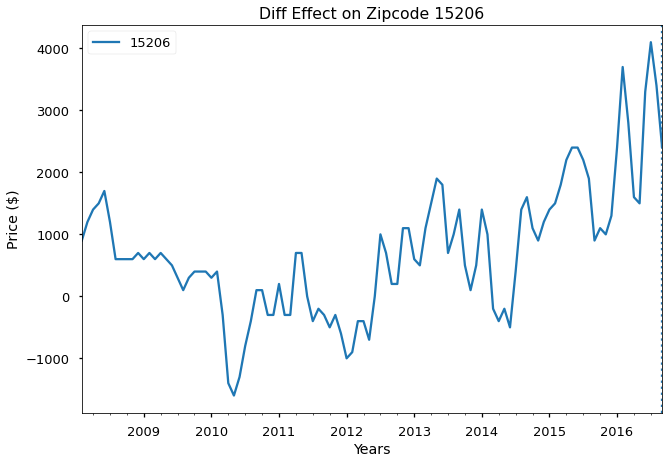

In [110]:
diff_results = remove_trends(train, "diff")

| --------------------- Log Effect on Zipcode 15206 ------------------------------ | 


| --- Zipcode 15206 --- | 

time
2008-01-01   11.28
2008-02-01   11.29
2008-03-01   11.31
2008-04-01   11.33
2008-05-01   11.34
              ... 
2016-05-01   11.86
2016-06-01   11.88
2016-07-01   11.91
2016-08-01   11.93
2016-09-01   11.95
Name: 15206, Length: 105, dtype: float64


 | -------------------- ADF Results for Zipcode 15206 ------------------------------ |


,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < 0.05,Stationary
Results: 15206,1.84,1.00,4,100,1.00,False,False




 | ------------------------ Visualizing Log Effect -------------------------------- |


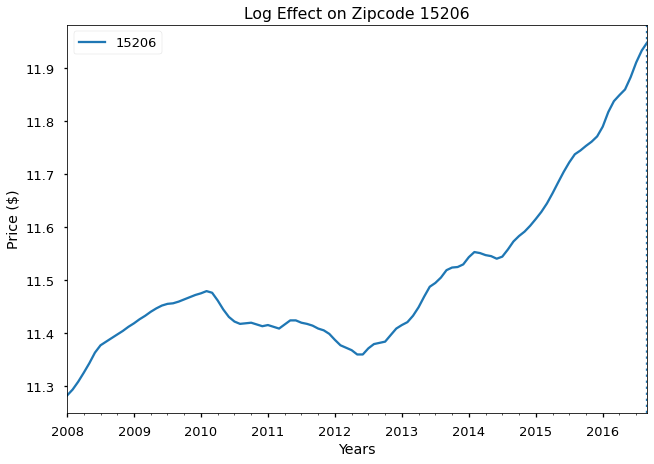

In [111]:
log_results = remove_trends(train, "log")

| --------------------- Rolling Mean Effect on Zipcode 15206 ------------------------------ | 


| --- Zipcode 15206 --- | 

time
2008-04-01   1,875.00
2008-05-01   2,125.00
2008-06-01   2,375.00
2008-07-01   2,125.00
2008-08-01   1,475.00
               ...   
2016-05-01   2,625.00
2016-06-01   3,625.00
2016-07-01   5,100.00
2016-08-01   5,425.00
2016-09-01   4,525.00
Name: 15206, Length: 102, dtype: float64


 | -------------------- ADF Results for Zipcode 15206 ------------------------------ |


,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < 0.05,Stationary
Results: 15206,-0.81,0.82,6,95,0.82,False,False




 | ------------------------ Visualizing Rolling Mean Effect -------------------------------- |


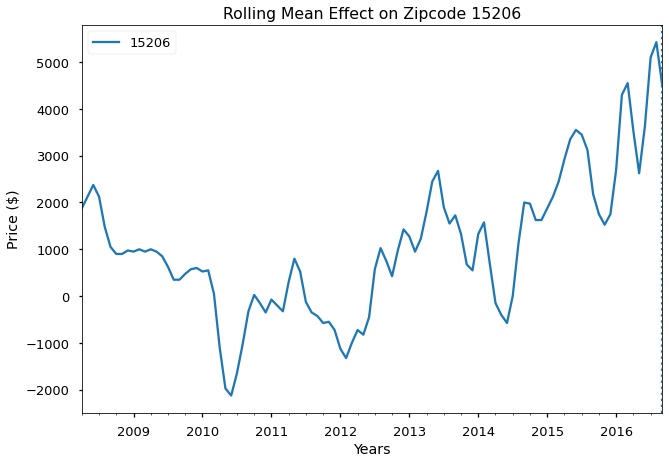

In [112]:
rolling_results = remove_trends(train, "rolling mean")

| --------------------- Ewm Effect on Zipcode 15206 ------------------------------ | 


| --- Zipcode 15206 --- | 

time
2008-01-01        0.00
2008-02-01      400.00
2008-03-01      944.26
2008-04-01    1,550.14
2008-05-01    2,142.79
                ...   
2016-05-01    7,817.79
2016-06-01    8,894.23
2016-07-01   10,395.39
2016-08-01   11,036.31
2016-09-01   10,749.05
Name: 15206, Length: 105, dtype: float64


 | -------------------- ADF Results for Zipcode 15206 ------------------------------ |


,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < 0.05,Stationary
Results: 15206,-0.42,0.91,3,101,0.91,False,False




 | ------------------------ Visualizing Ewm Effect -------------------------------- |


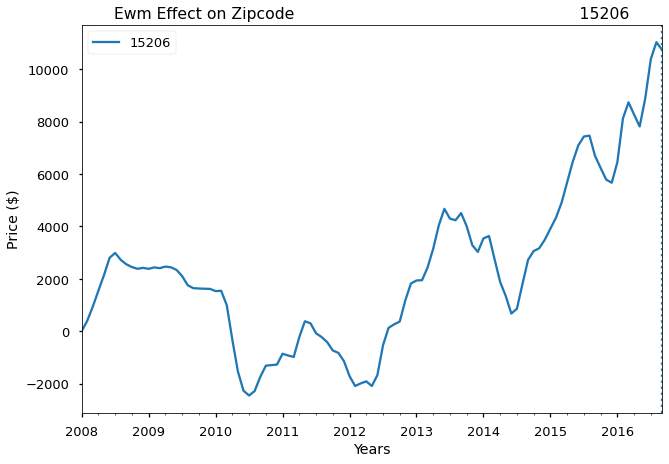

In [113]:
ewm_results = remove_trends(train, "EWM")

In [114]:
# methods = ['diff', 'log', 'rolling', 'EWM']

# method_results = {}

# for method in methods:
#     method_results[method] = (remove_trends(train, method))

In [115]:
# print(method_results.keys(),"\n\n")
# print("'diff' results:\n\n",method_results['diff'])

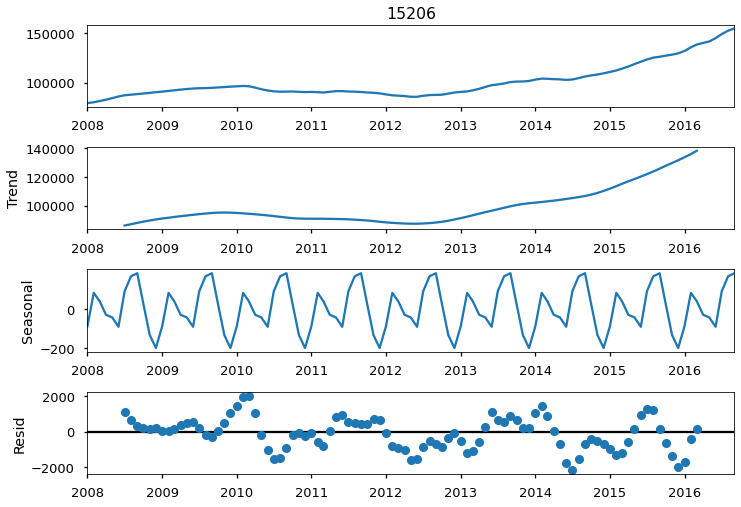

In [116]:
## Seasonal Decomposition
decomp = seasonal_decompose(test_zip)
decomp.plot();

<AxesSubplot:xlabel='time'>

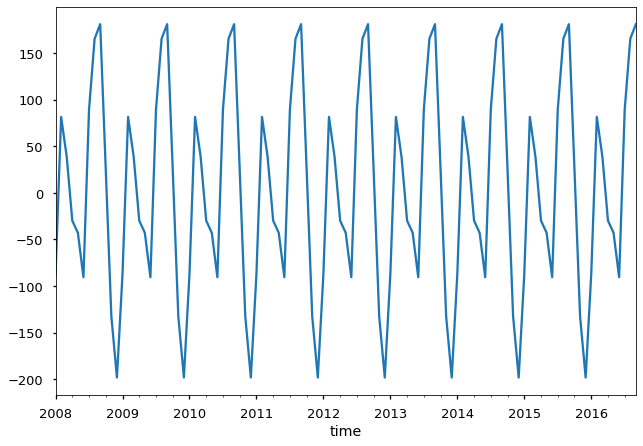

In [117]:
decomp.seasonal.plot()

In [118]:
## Save seasonal decomposition results to a dictionary.

decomp_dict = {'seasonal': decomp.seasonal,
              "trend": decomp.trend,
              'residuals': decomp.resid}

decomp_dict

{'seasonal': time
 2008-01-01   -87.20
 2008-02-01    81.55
 2008-03-01    38.84
 2008-04-01   -29.76
 2008-05-01   -42.86
               ...  
 2016-05-01   -42.86
 2016-06-01   -90.48
 2016-07-01    89.36
 2016-08-01   165.40
 2016-09-01   181.03
 Name: seasonal, Length: 105, dtype: float64, 'trend': time
 2008-01-01   nan
 2008-02-01   nan
 2008-03-01   nan
 2008-04-01   nan
 2008-05-01   nan
               ..
 2016-05-01   nan
 2016-06-01   nan
 2016-07-01   nan
 2016-08-01   nan
 2016-09-01   nan
 Name: trend, Length: 105, dtype: float64, 'residuals': time
 2008-01-01   nan
 2008-02-01   nan
 2008-03-01   nan
 2008-04-01   nan
 2008-05-01   nan
               ..
 2016-05-01   nan
 2016-06-01   nan
 2016-07-01   nan
 2016-08-01   nan
 2016-09-01   nan
 Name: resid, Length: 105, dtype: float64}

In [119]:
## Make a list of adfuller results to append
results = []
## Save results of orig ts
results.append(adf_test(train))

## Loop through decomp dict, 
for trend, ts_ in decomp_dict.items():
    # Fill any missing values, get adfuller result
    ts_ = ts_.fillna(0)
    res = adf_test(ts_)
    results.append(res)

    
    ## Append res to decomp_stationary

## make into a df
seasonality_df = pd.concat(results)
seasonality_df

,Test Stat,P-Value,Number of Lags Used,Number of Obs. Used,P-Value,p < 0.05,Stationary
Results: 15206,2.07,1.00,3,101,1.00,False,False
Results: seasonal,"-720,053,900,190,157.50",0.00,13,91,0.00,True,True
Results: trend,-2.54,0.11,0,104,0.11,False,False
Results: resid,-3.69,0.00,4,100,0.00,True,True


# ACF/PACF Check

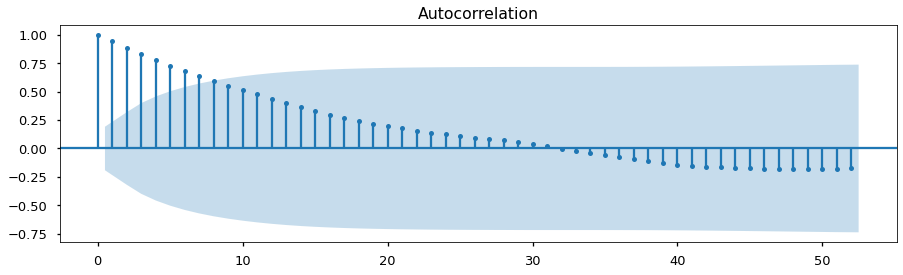

In [120]:
fig,ax=plt.subplots(figsize=(15, 4))
tsa.graphics.plot_acf(train,lags=52, ax=ax);

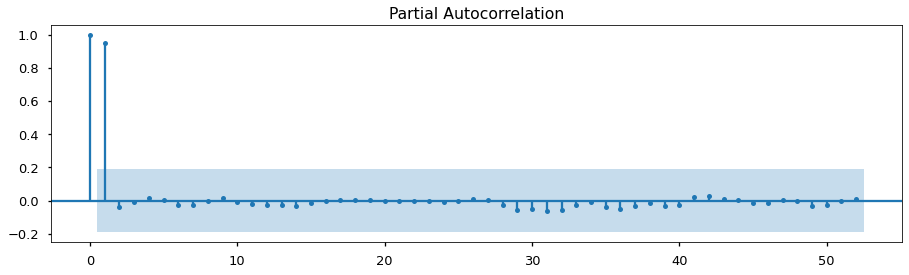

In [121]:
fig,ax=plt.subplots(figsize=(15.25, 4))
tsa.graphics.plot_pacf(train,lags=52, ax=ax);

In [122]:
def plot_acf_pacf(ts,figsize=(9,6),lags=52,suptitle=None,sup_x = .53, sup_y =1 ):
    """Plot pacf and acf using statsmodels
    
    Adapted from: https://github.com/flatiron-school/Online-DS-FT-022221-\
    Cohort-Notes/blob/master/Phase_4/topic_38_time_series_models/topic_38-\
    time_series_models_v3_SG.ipynb"""
    
    fig,axes=plt.subplots(nrows=2,figsize=figsize)
    
    tsa.graphics.plot_acf(ts,ax=axes[0],lags=lags);
    tsa.graphics.plot_pacf(ts,ax=axes[1],lags=lags);
    
    ## Add grid
    [ax.grid(axis='both',which='both') for ax in axes]
    
    axes[0].set_ylabel('Corr. Strength')
    axes[1].set_ylabel('Corr. Strength')
    
    if suptitle is not None:
        fig.suptitle(suptitle,x = sup_x, y=sup_y,fontweight='bold',fontsize=15)
        
    fig.tight_layout()
    return fig,axes

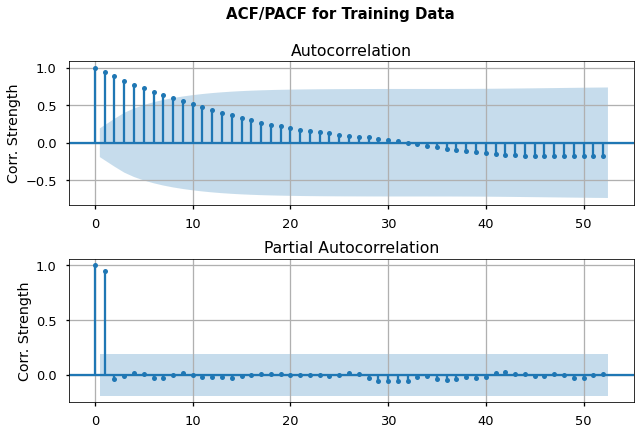

In [123]:
plot_acf_pacf(train, suptitle='ACF/PACF for Training Data');

# Auto-ARIMA

## Determining Best values for `d` and `D`

In [124]:
# ## Using pmdarima's functions to pre-determine the best values for 
# ## differencing prior to running auto_arima
# from pmdarima.arima import ndiffs
# from pmdarima.arima import nsdiffs

In [125]:
# ## Determine best value for d
# n_d = ndiffs(train)
# n_d

In [126]:
# ## Determine best value for D
# n_D = nsdiffs(train, m=12)
# n_D

In [127]:
# ## Inspecting the training data
# train.plot();

In [128]:
# ## Using auto_arima to determine best parameters for modeling
# auto_model = pmd.auto_arima(train,start_p=0,start_q=0,d=n_d,
#                             max_p=3,max_q=3,
#                             max_P=3,max_Q=3, D=n_D,
#                             start_P=0,start_Q=0,
#                             m=12,
#                             verbose=2)

# display(auto_model.summary())
# auto_model.plot_diagnostics(figsize= (12,9));
# plt.tight_layout()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.553
Date:                Wed, 25 Aug 2021   AIC                           1589.106
Time:                        09:35:26   BIC                           1591.741
Sample:                             0   HQIC                          1590.173
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.88e+05   3.37e+04      8.545      0.000    2.22e+05    3.54e+05
===================================================================================
Ljung-Box (Q):                      110.48   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               4.67   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

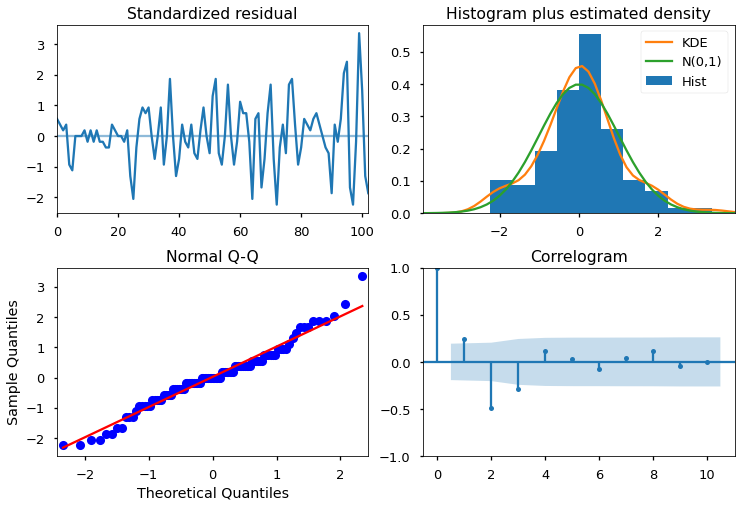

In [129]:
auto_arima_model = tsm.auto_arima_model(train)
tsm.model_results(auto_arima_model)

In [130]:
# best_model = tsa.SARIMAX(train,order=auto_model.order,
#                          seasonal_order = auto_model.seasonal_order,
#                          enforce_invertibility=False).fit()

# ## Display Summary + Diagnostics
# display(best_model.summary())
# best_model.plot_diagnostics(figsize=(12,9));
# plt.tight_layout()

C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.553
Date:                Wed, 25 Aug 2021   AIC                           1589.106
Time:                        09:35:28   BIC                           1591.741
Sample:                             0   HQIC                          1590.173
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.88e+05   3.37e+04      8.545      0.000    2.22e+05    3.54e+05
===================================================================================
Ljung-Box (Q):                      110.48   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               4.67   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  15206   No. Observations:                  105
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.553
Date:                Wed, 25 Aug 2021   AIC                           1589.106
Time:                        09:35:28   BIC                           1591.741
Sample:                    01-01-2008   HQIC                          1590.173
                         - 09-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.88e+05   3.37e+04      8.545      0.000    2.22e+05    3.54e+05
===================================================================================
Ljung-Box (Q):                      110.48   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               4.67   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

None

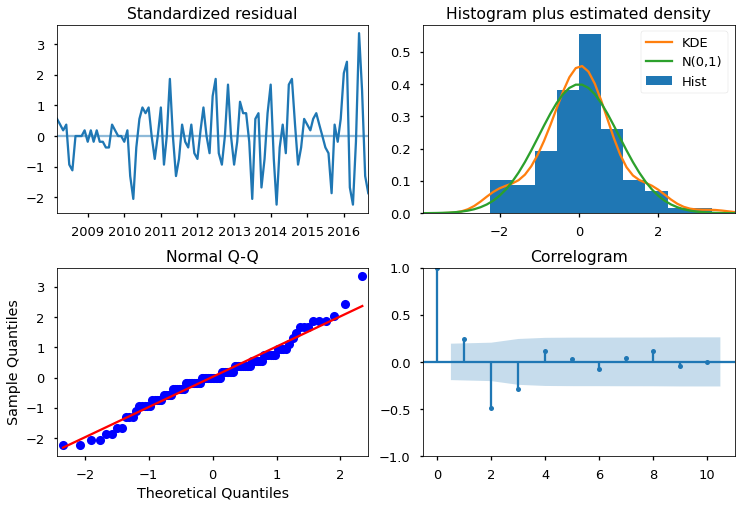

In [131]:
auto_model, best_model = tsm.create_best_model(train)

## Fit Best Model & Evaluate

In [132]:
# def calc_plot_best_model(train,start_p=0,max_p=5,start_q=0,max_q=5,d=1,m=52,
#                          start_P=0,start_Q=0, max_P=3, max_Q = 3, verbose = True):
    
#     auto_model = pmd.auto_arima(train, start_p = start_p, max_p = max_p,
#                            start_q = start_q, max_q = max_q, d = d ,m = m,
#                            start_P = start_P, start_Q = start_Q,
#                                 max_P = max_P, verbose=verbose)
    
#     display(auto_model.summary())
    
#     best_model = tsa.SARIMAX(train,order=auto_model.order,
#                              seasonal_order = auto_model.seasonal_order,
#                              enforce_invertibility=False).fit()
    
#     ## Display Summary + Diagnostics
#     display(best_model.summary())
#     best_model.plot_diagnostics();
#     plt.tight_layout()
    
#     return auto_model, best_model

In [133]:
# ## Using get_forecast to generate forecasted data
# forecast = best_model.get_forecast(steps=len(test))

# ## Saving confidence intervals and predicted mean for future
# forecast_df = forecast.conf_int()
# forecast_df.columns = ['Lower CI','Upper CI']
# forecast_df['Forecast'] = forecast.predicted_mean
# forecast_df.head(5)

In [134]:
forecast_df = tsm.forecast_and_ci(best_model, test_data = test)
forecast_df

,Lower CI,Upper CI,Forecast
2016-10-01,"156,048.26","158,151.74","157,100.00"
2016-11-01,"157,148.23","161,851.77","159,500.00"
2016-12-01,"157,964.74","165,835.26","161,900.00"
2017-01-01,"158,539.37","170,060.63","164,300.00"
2017-02-01,"158,900.07","174,499.93","166,700.00"
2017-03-01,"159,067.02","179,132.98","169,100.00"
2017-04-01,"159,055.62","183,944.38","171,500.00"
2017-05-01,"158,878.12","188,921.88","173,900.00"
2017-06-01,"158,544.55","194,055.45","176,300.00"
2017-07-01,"158,063.33","199,336.67","178,700.00"


In [135]:
# ## Plotting training, test data and forecasted results
# fig,ax = plt.subplots(figsize=(13,6))

# last_n_lags=12*5         

# train.iloc[-last_n_lags:].plot(label='Training Data')
# test.plot(label='Test Data')

# ## Plotting forecasted data and confidence intervals
# forecast_df['Forecast'].plot(ax=ax,label='Forecast')
# ax.fill_between(forecast_df.index,forecast_df['Lower CI'],
#                 forecast_df['Upper CI'],color='b',alpha=0.4)

# ax.set(xlabel='Time')
# ax.set(ylabel='Sell Price ($)')
# ax.set_title('Data and Forecasted Data')
# ax.legend();

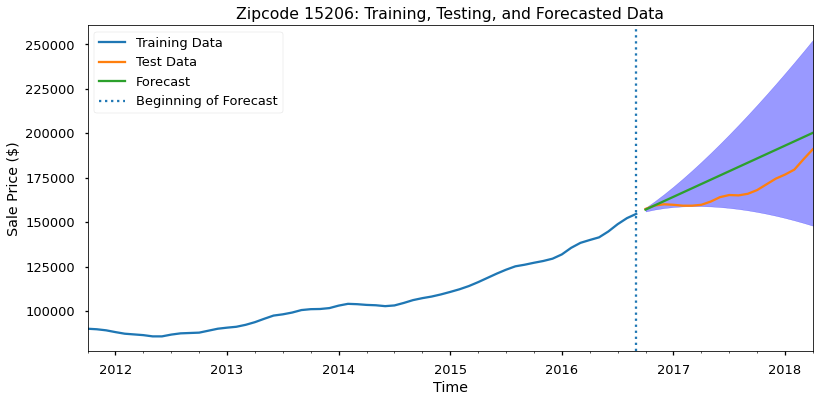

In [136]:
fig, ax = tsm.plot_forecast_ttf(train=train, test=test, forecast_df = forecast_df);

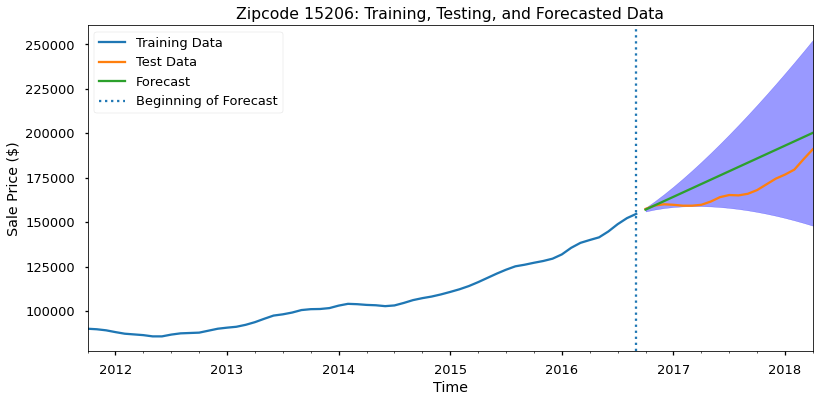

In [137]:
fig

## Forecasting

---

> Save `conf_int`, `predicted_mean` - 4cDF
>
>
> Plot Tr, Te, 4cDF

---

In [138]:
# best_model = tsa.SARIMAX(zipcode_val,order=auto_model.order,
#                          seasonal_order = auto_model.seasonal_order,
#                          enforce_invertibility=False).fit()

# display(best_model.summary())
# best_model.plot_diagnostics(figsize=(12,9));
# plt.tight_layout()

C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -966.218
Date:                Wed, 25 Aug 2021   AIC                           1934.437
Time:                        09:35:31   BIC                           1937.241
Sample:                             0   HQIC                          1935.576
                                - 124                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.431e+05   3.58e+04     12.390      0.000    3.73e+05    5.13e+05
===================================================================================
Ljung-Box (Q):                       89.09   Jarque-Bera (JB):                53.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.30   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  15206   No. Observations:                  124
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -966.218
Date:                Wed, 25 Aug 2021   AIC                           1934.437
Time:                        09:35:31   BIC                           1937.241
Sample:                    01-01-2008   HQIC                          1935.576
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.431e+05   3.58e+04     12.390      0.000    3.73e+05    5.13e+05
===================================================================================
Ljung-Box (Q):                       89.09   Jarque-Bera (JB):                53.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.30   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

None

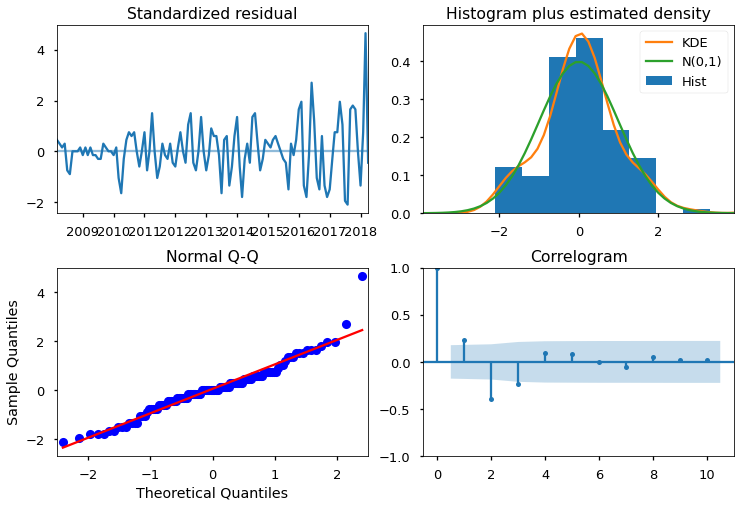

In [139]:
auto_model_best, best_model_overall = tsm.create_best_model(zipcode_val)

In [140]:
# ## Using get_forecast to generate forecasted data
# forecast = best_model.get_forecast(steps=24)

# ## Saving confidence intervals and predicted mean for future
# forecast_df = forecast.conf_int()
# forecast_df.columns = ['Lower CI','Upper CI']
# forecast_df['Forecast'] = forecast.predicted_mean
# forecast_df.head(5)

In [141]:
# ## Plotting training, test data and forecasted results
# fig,ax = plt.subplots(figsize=(13,6))

# zipcode_val.plot(label='Training Data')

# ## Plotting forecasted data and confidence intervals
# forecast_df['Forecast'].plot(ax=ax,label='Forecast')
# ax.fill_between(forecast_df.index,forecast_df['Lower CI'],
#                 forecast_df['Upper CI'],color='b',alpha=0.4)

# ax.set(xlabel='Time')
# ax.set(ylabel='Sale Price ($)')
# ax.set_title('Data and Forecasted Data')
# ax.legend();

In [154]:
forecast_overall = tsm.forecast_and_ci(best_model_overall, n_yrs_future = 2)
forecast_overall

,Lower CI,Upper CI,Forecast
2018-05-01,"195,395.36","198,004.64","196,700.00"
2018-06-01,"199,382.75","205,217.25","202,300.00"
2018-07-01,"203,018.50","212,781.50","207,900.00"
2018-08-01,"206,354.22","220,645.78","213,500.00"
2018-09-01,"209,424.56","228,775.44","219,100.00"
2018-10-01,"212,254.57","237,145.43","224,700.00"
2018-11-01,"214,863.34","245,736.66","230,300.00"
2018-12-01,"217,266.07","254,533.93","235,900.00"
2019-01-01,"219,475.21","263,524.79","241,500.00"
2019-02-01,"221,501.20","272,698.80","247,100.00"


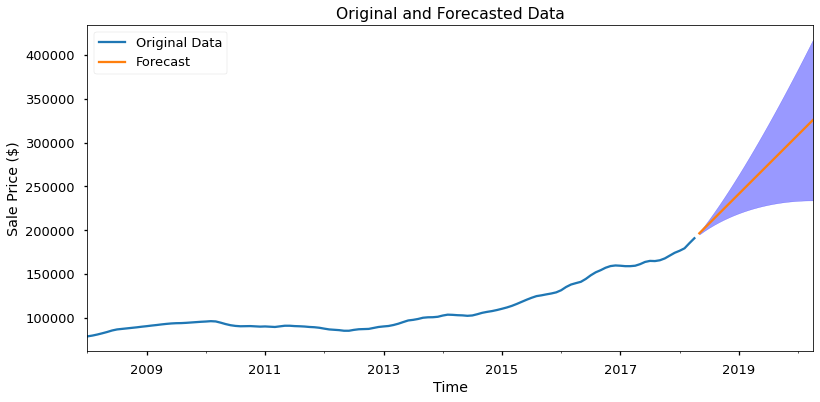

In [155]:
fig, ax = tsm.plot_forecast_final(zipcode_val, forecast_overall)

In [158]:
investment_cost = forecast_df.iloc[0,2]
investment_cost

157100.0

In [159]:
roi_df = (forecast_df - investment_cost)/investment_cost*100
roi_df

,Lower CI,Upper CI,Forecast
2016-10-01,-0.67,0.67,0.00
2016-11-01,0.03,3.02,1.53
2016-12-01,0.55,5.56,3.06
2017-01-01,0.92,8.25,4.58
2017-02-01,1.15,11.08,6.11
2017-03-01,1.25,14.02,7.64
2017-04-01,1.24,17.09,9.17
2017-05-01,1.13,20.26,10.69
2017-06-01,0.92,23.52,12.22
2017-07-01,0.61,26.89,13.75


In [160]:
roi_final = roi_df.iloc[-1]
roi_final.name = zipcode_val.name.astype('str')
roi_final

Lower CI   -5.77
Upper CI   60.77
Forecast   27.50
Name: 15206, dtype: float64

In [151]:
pd.DataFrame(roi_final)

,15206
Lower CI,-5.77
Upper CI,60.77
Forecast,27.50


# Interpreting Results

---

> Based on my model, the ROI for the zipcode 15206 would be an average of 65.48%. However, the results may fall anywhere between 19.05% - 111.91%.

---

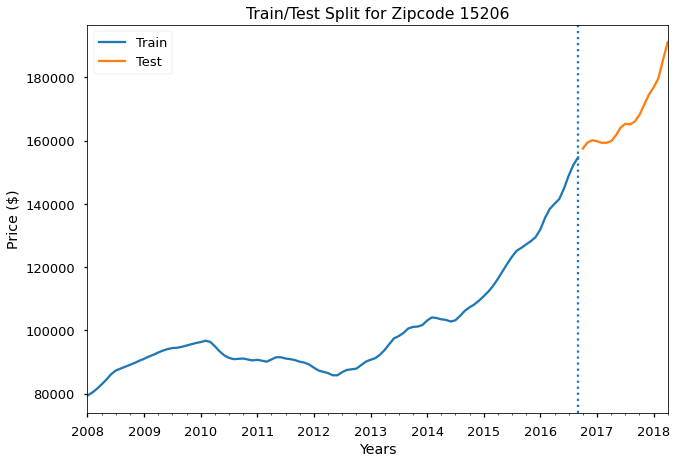

C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.553
Date:                Wed, 25 Aug 2021   AIC                           1589.106
Time:                        09:54:47   BIC                           1591.741
Sample:                             0   HQIC                          1590.173
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.88e+05   3.37e+04      8.545      0.000    2.22e+05    3.54e+05
===================================================================================
Ljung-Box (Q):                      110.48   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               4.67   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  15206   No. Observations:                  105
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.553
Date:                Wed, 25 Aug 2021   AIC                           1589.106
Time:                        09:54:47   BIC                           1591.741
Sample:                    01-01-2008   HQIC                          1590.173
                         - 09-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.88e+05   3.37e+04      8.545      0.000    2.22e+05    3.54e+05
===================================================================================
Ljung-Box (Q):                      110.48   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               4.67   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

None

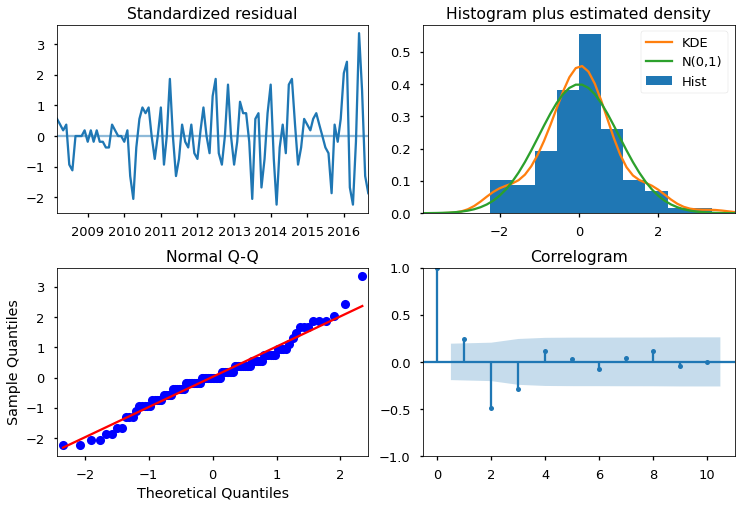

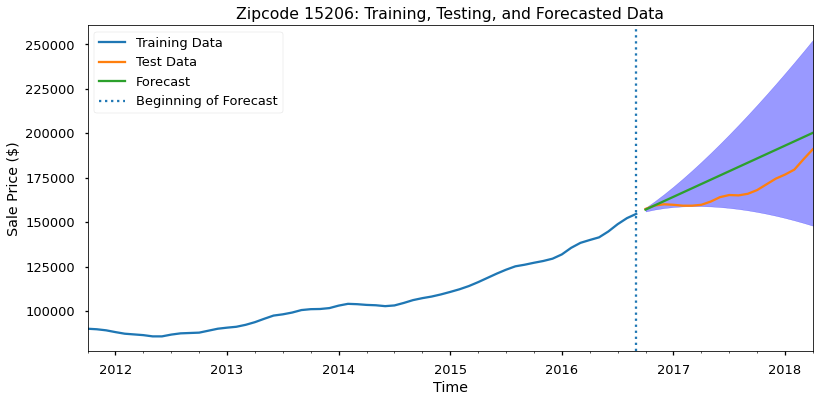

C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\bmcca\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  15206   No. Observations:                  124
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -966.218
Date:                Wed, 25 Aug 2021   AIC                           1934.437
Time:                        09:54:48   BIC                           1937.241
Sample:                    01-01-2008   HQIC                          1935.576
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.431e+05   3.58e+04     12.390      0.000    3.73e+05    5.13e+05
===================================================================================
Ljung-Box (Q):                       89.09   Jarque-Bera (JB):                53.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.30   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

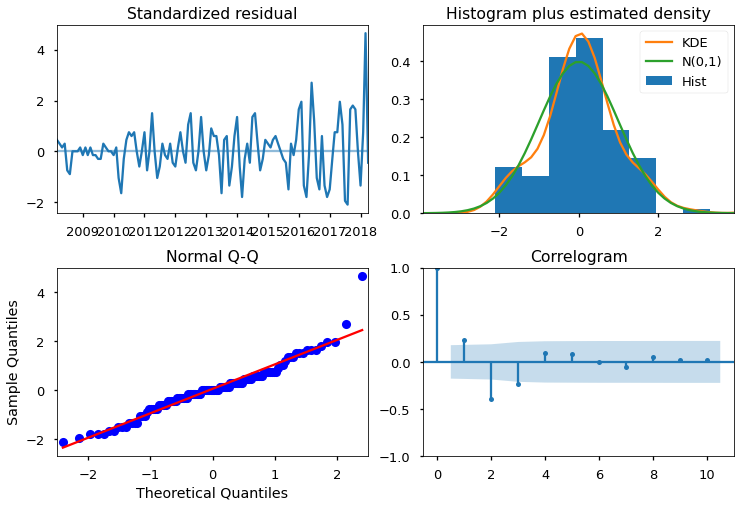

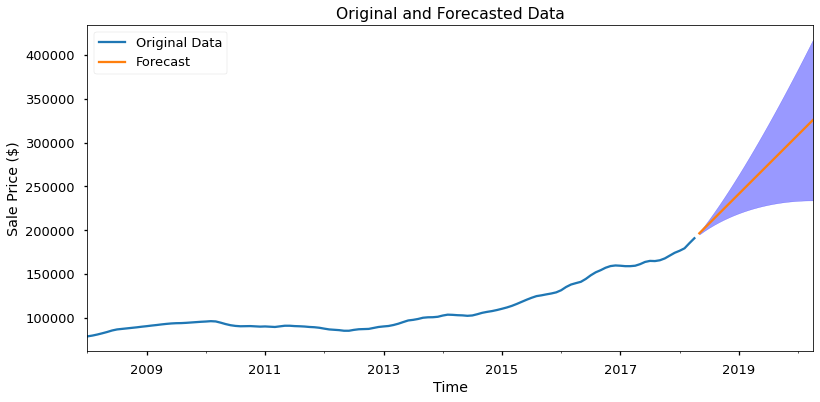

In [162]:
forecast_overall, roi_final, best_model_perf, final_fig = tsm.ts_modeling_workflow(zipcodes_df, 15206)

# Storing Results (Dictionary)

---

> [See this link](https://www.youtube.com/watch?v=atUym8mOnNc&list=PLFknVelSJiSxSwXifV_ysDg50fzbuTzVt&index=59)

---

# Processing Remaining Zip Codes

---

> Now I will process the remaining zip codes of the 10-year zipcode dataframe.
>
>
> **To make the process easier, I converted the modeling process into a single function, accessible in my personal module in this repository.**
>
>
> I will loop through the remaining zipcodes and run them through the workflow. As part of the workflow, I will review each model's performance to ensure it is appropriate for forecasting.
>
>
>I will save the results to the overall dictionary for my final review and interpretation.

---

# ❌ **RAISE ERROR** ❌

In [150]:
raise ValueError('Old notebook code below - DO NOT RUN')

ValueError: Old notebook code below - DO NOT RUN

# 
TODO: manually code, then  functionize

In [ ]:
def forecast_and_plot(train, test, final_ts = None, model, last_n_lags=52,
                      x_label, y_label, figsize=(10,4)):

    ## Get forecast
    forecast = model.get_forecast(steps=len(test))

    ## Save forecasted mean, upper/lower CI as DF
    forecast_df = forecast.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df['Forecast'] = forecast.predicted_mean

    # Plotting timeseries data
    fig,ax = plt.subplots(figsize=figsize)
    
    last_n_lags=last_n_lags
    
    if final_ts is None:
        train.iloc[-last_n_lags:].plot(label='Training Data')
        test.plot(label='Test Data')
    else:
        ts.iloc[-last_n_lags:].plot(label='Training Data')
        ax.axvline(ts.index[-1],ls=':')

    ## Plotting forecast and CI
    forecast_df['Forecast'].plot(ax=ax,label='Forecast')
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], 
                    forecast_df['Upper CI'],color='g',alpha=0.3)

    ax.set(xlabel=x_label)
    ax.set(ylabel=y_label)
    ax.legend()
    plt.show();
    
    return forecast_df

In [ ]:
def get_df_from_pred(forecast_or_pred,forecast_label='Forecast'):
    """Takes a PredictionResultsWrapper from statsmodels
    extracts the confidence intervals and predicted mean and returns in a df"""
    forecast_df = forecast_or_pred.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df[forecast_label] = forecast_or_pred.predicted_mean
    return forecast_df

def plot_forecast_from_df(forecast_df,ts_diff=None,orig_label='True Data',
                          forecast_label='Forecast',
                          last_n_lags=52,figsize=(10,4)):
    """Takes a forecast_df from get_df_from_pred and optionally 
    the training/original time series.
    
    Plots the original ts, the predicted mean and the 
    confidence invtervals (using fill between)"""
    fig,ax = plt.subplots(figsize=figsize)

    if ts_diff is not None:
        ts_diff.iloc[-last_n_lags:].plot(label='True Data')
        
   
    forecast_df['Forecast'].plot(ax=ax,label=forecast_label)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], 
                    forecast_df['Upper CI'],color='g',alpha=0.3)
    ax.legend()
    ax.set(title=f'Forecasted {ts_diff.name}')
    return fig,ax\

## Run on Full Dataset for Final Results

In [ ]:
## If happy with the model's test perforamance, retrain on entire ts and forecast into future
## Fit a final model and evaluate
final_model = tsa.SARIMAX(ts,order=auto_model.order,
                seasonal_order = auto_model.seasonal_order,
                enforce_invertibility=False).fit()


## Display Summary + Diagnostics
display(final_model.summary())
final_model.plot_diagnostics();
plt.tight_layout()

In [ ]:
## Get forecast 
forecast = final_model.get_forecast(steps=len(test))

## save forecasted mean and upper/lower ci as df
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = forecast.predicted_mean

## Plot
last_n_lags=52

fig,ax = plt.subplots(figsize=(10,4))

                      
# Plotting Training and test data
ts.iloc[-last_n_lags:].plot(label='Training Data')
ax.axvline(ts.index[-1],ls=':')
# test.plot(label='Test Data')

## Plotting Forefcast and CI
forecast_df['Forecast'].plot(ax=ax,label='Forecast')
ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)

ax.set(ylabel='Crime Count')
ax.legend()

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

## Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format.

## Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!

# Reading Data

In [ ]:
# # import warnings
# # warnings.filterwarnings('ignore')

# ## Data Handling
# import pandas as pd
# import numpy as np

# ## Visualizations
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sns

# import statsmodels
# import statsmodels.tsa.api as tsa
# from statsmodels.tsa.seasonal import seasonal_decompose

# import pmdarima as pmd

# ## Settings
# %matplotlib inline
# plt.rcParams['figure.figsize']=(12,6)
# plt.style.use('seaborn-talk')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
# pd.set_option('max_rows', 100)

# from bmc_functions import eda

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
# ## ImportingReading in-Dta
# source = '../data/zillow_data.csv'
# data = pd.read_csv(source)
# data.head(5)

In [ ]:
# data.info()

# Filtering Data

---

> The dataset is much larger than I need for my purposes, so I will determine a smaller regional subset for analysis.
>
>
> As I am from Pittsburgh, PA, I will select that region for my models.

---

In [ ]:
# ## Selecting Pittsburgh Metro Area

# pitt_df = data[data['City'] == 'Pittsburgh']
# pitt_df

In [ ]:
# ## Examining Statistics for the Pittsburgh Metro area
# eda.report_df(pitt_df).T

In [ ]:
# ## Inspecting overall data for CA - transposed and dropping RegionID, SizeRank

# pitt_zips = pitt_df.pivot_table(index= 'RegionName').T[:-2]
# pitt_zips

# Data Preprocessing

In [ ]:
# def get_datetimes(df):
#     """
#     Takes a dataframe:
#     returns only those column names that can be converted into datetime objects 
#     as datetime objects.
#     NOTE number of returned columns may not match total number of columns in passed dataframe
#     """
    
#     return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [ ]:
# pitt_df.columns.values[7:] = get_datetimes(pitt_df)
# pitt_df

# Melting DataFrame

In [ ]:
# def melt_data(df):
#     """
#     Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
#     Returns a long-form datetime dataframe with the datetime column names
#     as the index and the values as the 'values' column.
    
#     If more than one row is passes in the wide-form dataset, the values column
#     will be the mean of the values from the datetime columns in all of the rows.
#     """
    
#     melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank',
#                                   'City', 'State', 'Metro', 'CountyName'],
#                      var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted#.groupby('time').aggregate({'value':'mean'})

In [ ]:
# pitt_melted = melt_data(pitt_df)
# pitt_melted

## Old Code - Pivot Table

In [ ]:
# ## Inspecting overall data for Pittsburgh

# pitt_df.pivot_table(index= 'RegionName')

In [ ]:
# ## Inspecting overall data for CA - transposed and dropping RegionID, SizeRank

# pitt_zips = pitt_df.pivot_table(index= 'RegionName').T[:-2]
# pitt_zips

# Step 3: EDA and Visualization

In [ ]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# mpl.rc('font', **font)

# # NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [ ]:
# ## Generating initial statistical overview
# report = eda.report_df(pitt_df)
# report

In [ ]:
## Inspecting only zip codes with missing columns
# report[report['null_sum'] >0]

In [ ]:
# ## Selecting zipcode with largest number of entries
# most_freq_zip = report['count'].sort_values(ascending=False)[:1]
# most_freq_zip

In [ ]:
# ## Checking for missing values pre-visualizing
# pitt_zips[15243].isna().sum()

In [ ]:
# test_zip = pitt_zips[15243]

In [ ]:
# ## Initial visualization of one zipcode
# test_zip.plot();

# FIX/REMOVE JMI FUNCTION

In [ ]:
# ## Lab Function
# # from statsmodels.tsa.stattools import adfuller

# def adfuller_test_df(ts,index=['AD Fuller Results']):
#     """Returns the AD Fuller Test Results and p-values for the null hypothesis
#     that there the data is non-stationary (that there is a unit root in the data)"""
    
#     df_res = tsa.stattools.adfuller(ts)
    
#     names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
#     res  = dict(zip(names,df_res[:4]))
    
#     res['p<.05'] = res['p-value']<.05
#     res['Stationary?'] = res['p<.05']
    
#     if isinstance(index,str):
#         index = [index]
#     res_df = pd.DataFrame(res,index=index)
#     res_df = res_df[['Test Statistic','#Lags Used',
#                      '# of Observations Used','p-value','p<.05',
#                     'Stationary?']]
#     return res_df



# def stationarity_check(TS,window=8,plot=True,index=['AD Fuller Results']):
#     """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
#     # Calculate rolling statistics
#     roll_mean = TS.rolling(window=window, center=False).mean()
#     roll_std = TS.rolling(window=window, center=False).std()
    
#     # Perform the Dickey Fuller Test
#     dftest = adfuller_test_df(TS,index=index)
    
#     if plot:
#         # Plot rolling statistics:
#         fig = plt.figure(figsize=(12,6))
#         plt.plot(TS, color='blue',label=f'Original (freq={TS.index.freq})')
#         plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
#         plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
#         plt.legend(loc='best')
#         plt.title('Rolling Mean & Standard Deviation')
#         display(dftest)
#         plt.show(block=False)
        
#     return dftest
    

In [ ]:
# from statsmodels.tsa.stattools import adfuller
# results = stationarity_check(test_zip)

In [ ]:
# tz_diff = test_zip.diff().dropna()
# tz_diff.plot()
# adfuller_test_df(tz_diff)

In [ ]:
# ## Log Transform, plot and get adfuller test
# tz_log = np.log(test_zip)
# tz_log.plot()
# adfuller_test_df(tz_log)

In [ ]:
# ## Subtract Rolling mean
# tz_rm = test_zip - test_zip.rolling(window=4).mean()
# tz_rm.dropna(inplace=True)
# tz_rm.plot()
# adfuller_test_df(tz_rm)

In [ ]:
# tz_ewm = test_zip-test_zip.ewm(4).mean()
# tz_ewm.dropna(inplace=True)
# tz_ewm.plot()
# adfuller_test_df(tz_ewm)

In [ ]:
# decomp = seasonal_decompose(test_zip)
# decomp.plot();

In [ ]:
# decomp.seasonal

In [ ]:
# ## Save seasonal/trend/resid in a dictionary.

# decomp_dict = {'seasonal': decomp.seasonal,
#               "trend": decomp.trend,
#               'residuals': decomp.resid}

# decomp_dict

In [ ]:
# ## Make a list of adfuller results to append
# results = []
# ## Save results of orig ts
# results.append(adfuller_test_df(test_zip,index=['Original']))

# ## Loop through decomp dict, 
# for trend, ts_ in decomp_dict.items():
#     # Fill any missing values, get adfuller result
#     ts_ = ts_.fillna(0)
#     res = adfuller_test_df(ts_,index=trend)
#     results.append(res)

    
#     ## Append res to decomp_stationary

# ## make into a df
# res_df = pd.concat(results)
# res_df

In [ ]:
# ## Pldot decomp again for convenient comparison
# decomp.plot();

# Step 5: ARIMA Modeling

In [ ]:
# test_zip.plot()

In [ ]:
# ## Use auto_arima 
# auto_model = pmd.auto_arima(test_zip.loc['2008':],start_p=0,start_q=0,d=1,
#                             max_p=3,max_q=3,
#                             max_P=3,max_Q=3,
#                             start_P=0,start_Q=0,
#                             m=12,
#                             verbose=2)

In [ ]:
# display(auto_model.summary())
# auto_model.plot_diagnostics();
# plt.tight_layout()

In [ ]:
# tz_diff = test_zip.diff().dropna()
# tz_diff

In [ ]:
# adfuller_test_df(tz_diff)

In [ ]:
# am_diff = pmd.auto_arima(test_zip,start_p=0,start_q=0, d=1,
#                             max_p=4,max_q=3,
#                             max_P=3,max_Q=2,
#                             start_P=0,start_Q=0,
#                             m=12,
#                             verbose=2)

In [ ]:
# display(am_diff.summary())
# am_diff.plot_diagnostics();
# plt.tight_layout()

In [ ]:
# ### From SARIMA Models Lab
# import itertools
# from tqdm.notebook import trange
# # Define the p, d and q parameters to take any value between 0 and 2
# ps = list(range(0,4))
# ds = list(range(0,2))
# qs = list(range(0,3))

# # Generate all different combinations of p, q and q triplets
# pdq_list = list(itertools.product(ps,ds, qs))
# pdq_list

In [ ]:
# ## Loop through pdq_list, make an ARIMA model
# # save p,d,q and aic to a model_aic list
# model_aics= [['p','d','q','aic']]

# ## Make Results into a df and sort by aic
# for i in trange(len(pdq_list)):
#     p,d,q = pdq_list[i]
#     model = tsa.arima.ARIMA(ts,order=(p,d,q),enforce_invertibility=False).fit()
#     model_aics.append([p,d,q,model.aic])
#     print(f'For ({p},{d},{q}), aic = {model.aic:.3f}')

# results = pd.DataFrame(model_aics[1:],columns=model_aics[0]).sort_values('aic')
# results